In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
from math import atan2
import timeit

In [3]:
def normalize(vect):
    norm = np.sqrt(np.dot(vect,vect))
    return vect/norm #don't use me with np.zeroes(#)

R_e = 6378137.0 
R_p = 6356752.31425 

def proj_ellipsoid(R_e, R_p, p, verbose=False, numerical_min=True):
    x, y, z = p
    phi = atan2(y, x)
    d = np.sqrt(x**2+y**2)
    r = np.linalg.norm(p)
    alpha = np.sqrt(d**2/R_e**2 + z**2/R_p**2) #facteur d'homothétie
    
    #on peut développer/chercher en theta autour de:
    theta_0 = np.arccos(z/(alpha*R_p))
    if numerical_min:
        def G(theta):
            terme_cst = r**2+R_p**2
            terme_sin2 = (R_e**2-R_p**2)*np.sin(theta)**2
            terme_sin = -2*R_e*d*np.sin(theta)
            terme_cos = -2*R_p*z*np.cos(theta)
            return terme_cst+terme_sin2+terme_cos+terme_sin
    
        #numerical minimization
        solve_bisec = opt.minimize_scalar(G, bounds=(.9999*theta_0,1.0001*theta_0), method='bounded')
        theta_sol = solve_bisec.x
    else:
        #analytical minimization (linearization; use me only with points close to the ellipsoid)
        #marginally faster
        ct = np.cos(theta_0)
        st = np.sin(theta_0)
        delta_theta_num = -1*(ct*st*(R_e**2-R_p**2) - R_e*d*ct + R_p*z*st)
        delta_theta_den = ((ct*ct-st*st)*(R_e**2-R_p**2) + R_e*d*st + R_p*z*ct)
        delta_theta = delta_theta_num/delta_theta_den
        theta_sol = theta_0+delta_theta

    if verbose:
        check_dtetha_vals = np.linspace(-1e-7,1e-7,51)
        check_vals = np.array([np.sqrt(G(theta_0+dtheta)) for dtheta in check_dtetha_vals])
        plt.plot(check_dtetha_vals, check_vals)
        plt.axvline(theta_sol-theta_0, c='g')

    x_sol = R_e*np.sin(theta_sol)*np.cos(phi)
    y_sol = R_e*np.sin(theta_sol)*np.sin(phi)
    z_sol = R_p*np.cos(theta_sol)
    return np.array([x_sol, y_sol, z_sol])


def height_above_ellispoid(p, numerical_min=True):
    p_proj = proj_ellipsoid(R_e, R_p, p, numerical_min = numerical_min)
    sign_height = np.sign((p[0]**2+p[1]**2)/R_e**2 + (p[2]/R_p)**2 - 1)
    return sign_height*np.linalg.norm(p_proj-p)


def pointcloud_ellipsoidgeoloc_improved(p, s, vs, 
                                        R_target, h_target, 
                                        keep_Doppler=False, 
                                        #if False uses 0 Doppler, else the value computed from p, s, bs
                                        keep_R=False,
                                        verbose = False,
                                        numerical_proj = True):
    
    s_hat = normalize(s)
    # let's define first an adapted orthonormal basis
    v_hat = normalize(vs) #points along track
    u_hat = normalize(np.cross(s_hat, v_hat)) #s and v are almost ortho; no danger of colinear (points roughly cross track)
    w_hat = np.cross(u_hat, v_hat) # points roughly to nadir
    
    r_s = np.linalg.norm(s)
    
    delta = np.dot(p-s,v_hat) if keep_Doppler else 0.
    R = np.linalg.norm(p-s) if keep_R else R_target
    
    # let's choose the sign of mu (discriminates between both swaths) based on the input point
    mu_input_sign = np.sign(np.dot(p-s,u_hat))

    def point_on_circle_rangeDoppler(mu):
        r_eq = np.sqrt(R**2-delta**2)
        return s + r_eq*(np.cos(mu)*w_hat + np.sin(mu)*u_hat) + delta*v_hat
    
    def dist_point_to_proj_minush(mu):
        p_mu = point_on_circle_rangeDoppler(mu)
        d = height_above_ellispoid(p_mu, numerical_min=numerical_proj)
        return (d-h_target)**2

    bounds_chooseside = (0., 6*np.pi/180.) if mu_input_sign>0 else (-6*np.pi/180., 0.)
    sol = opt.minimize_scalar(dist_point_to_proj_minush,
                               bounds=bounds_chooseside,
                               method='bounded')#uses bisection since this is a 1D problem
    mu_sol = sol.x
    p_new = point_on_circle_rangeDoppler(mu_sol)

    if verbose:
        #print(sol)
        print(mu_sol)
        check_dmu_vals = np.linspace(-.001,.001,300)
        check_vals = np.array([np.sqrt(dist_point_to_proj_minush(mu_sol+dmu)) for dmu in check_dmu_vals])
        plt.plot(check_dmu_vals, check_vals)
        plt.show()
    
        check_dmu_vals = np.linspace(-.05,.05,300)
        check_vals = np.array([np.sqrt(dist_point_to_proj_minush(dmu)) for dmu in check_dmu_vals])
        plt.plot(check_dmu_vals, check_vals)
        plt.axvline(mu_sol, c='r')
        #print(np.array([np.linalg.norm(p_new-s)-R,np.dot(normalize(p_new-s),v_hat),height_above_ellispoid(p_new)]))
    
    return p_new

In [4]:
p_test = np.array([4429662.87177, 887470.118554, 4487262.47752])
s_test = np.array([ 5052547.95238, 1052933.69588, 5115928.23432])
vs_test = np.array([ -5341.44828678, 819.4300598, 5076.67508892 ])

h_test = 11.7834 
R_test = 900324.748127

h_brut = 8.81399

In [5]:
ti = timeit.time.time()
p_res = pointcloud_ellipsoidgeoloc_improved(p_test, s_test, vs_test, 
                                            R_test, h_brut,
                                            keep_Doppler=True,
                                            keep_R=True,
                                            verbose=False,
                                            numerical_proj=True)
tf = timeit.time.time()
print(tf-ti)

0.004784107208251953


In [6]:
print(p_res)
print(p_test)
print(p_res-p_test)
print(np.linalg.norm(p_res-p_test))

[ 4429662.85341361   887470.48698405  4487262.39873766]
[ 4429662.87177    887470.118554  4487262.47752 ]
[-0.01835639  0.36843005 -0.07878234]
0.377205931476


In [36]:
ti = timeit.time.time()
p_res = pointcloud_ellipsoidgeoloc_improved(p_test, s_test, vs_test, 
                                            R_test,h_test,
                                            keep_Doppler=False,
                                            keep_R=False,
                                            verbose=False,
                                            numerical_proj=False)
tf = timeit.time.time()
print(tf-ti)

0.0014350414276123047


In [31]:
print(p_res)
print(p_test)
print(p_res-p_test)
print(np.linalg.norm(p_res-p_test))

[ 4429690.04639167   886909.53693652  4487383.35948219]
[ 4429662.87177    887470.118554  4487262.47752 ]
[  27.17462166 -560.58161748  120.88196219]
574.110319276


In [37]:
ti = timeit.time.time()
p_res_T = pointcloud_ellipsoidgeoloc_improved_Taylortheta2mu1(p_test, s_test, vs_test, 
                                            R_test,3*h_test,
                                            keep_Doppler=True,
                                            keep_R=False,
                                            verbose=True)
tf = timeit.time.time()
print(tf-ti)

0.0004718303680419922


In [38]:
print(p_res_T)
print(p_test)
print(p_res_T-p_test)
print(np.linalg.norm(p_res_T-p_test))
print(np.linalg.norm(p_res_T-p_res))
print(height_above_ellispoid(p_res_T, numerical_min=True), h_test)

[ 4429691.29145696   886902.35673714  4487384.0223061 ]
[ 4429662.87177    887470.118554  4487262.47752 ]
[  28.41968696 -567.76181686  121.5447861 ]
581.321162797
516.809894806
35.6209681857 11.7834


In [39]:
def pointcloud_ellipsoidgeoloc_improved_Taylortheta2mu1(p_noisy, s, vs, 
                                        R_target, h_target, 
                                        keep_Doppler=False, 
                                        #if False uses 0 Doppler, else the value computed from p, s, bs
                                        keep_R=False,
                                        verbose = False):
    
    s_hat = normalize(s)
    # let's define first an adapted orthonormal basis
    v_hat = normalize(vs) #points along track
    u_hat = normalize(np.cross(s_hat, v_hat)) #s and v are almost ortho; no danger of colinear (points roughly cross track)
    w_hat = np.cross(u_hat, v_hat) # points roughly to nadir
    
    r_s = np.linalg.norm(s)
    
    delta = np.dot(p_noisy-s,v_hat) if keep_Doppler else 0.
    R = np.linalg.norm(p_noisy-s) if keep_R else R_target
    
    #OLDlet's choose the sign of mu (discriminates between both swaths) based on the input point
    # mu_input_sign = np.sign(np.dot(p_noisy-s,u_hat))
    
    #initial guess for mu uses the input point for now
    mu = atan2(np.dot(p_noisy-s,u_hat),np.dot(p_noisy-s,w_hat))
    
    h_noisy = height_above_ellispoid(p_noisy, numerical_min=False)
    r_eq = np.sqrt(R**2-delta**2)
    mu += (h_target-h_brut)/r_eq/np.sin(mu) #tweak the intial guess: move by dh in the w_hat direction 
    
    
    p_mu = s + r_eq*(np.cos(mu)*w_hat + np.sin(mu)*u_hat) + delta*v_hat
    dp_mu_dmu = r_eq*(-np.sin(mu)*w_hat + np.cos(mu)*u_hat)
        
    r2_mu = np.dot(p_mu,p_mu)
    z_mu = p_mu[2]
    d_mu = np.sqrt(r2_mu-z_mu*z_mu)
        
    dr2_dmu = 2*np.dot(p_mu,dp_mu_dmu)
    dz_dmu = dp_mu_dmu[2]
    dd_dmu = (dr2_dmu/2.-z_mu*dz_dmu)/d_mu

    
    #initial guess for theta
    alpha = np.sqrt(d_mu**2/R_e**2 + z_mu**2/R_p**2) #homotethy factor for an ellipsoid going through p_noisy
    theta_0 = np.arccos(z_mu/(alpha*R_p))
    
    DR2 = R_e**2-R_p**2
    s_th, c_th = np.sin(theta_0), np.cos(theta_0)
    s_th2 , c_th2 = s_th**2, c_th**2
    G = r2_mu+R_p**2 + DR2*s_th2 - 2*R_e*d_mu*s_th - 2*R_p*z_mu*c_th
    dG_dth = 2*DR2*s_th*c_th - 2*R_e*d_mu*c_th + 2*R_p*z_mu*s_th
    d2G_dth2 = 2*DR2*(c_th2-s_th2) + 2*R_e*d_mu*s_th + 2*R_p*z_mu*c_th
    dG_dmu = dr2_dmu - 2*R_e*dd_dmu*s_th -2*R_p*dz_dmu*c_th
    d2G_dthdmu = -2*R_e*dd_dmu*c_th + 2*R_p*dz_dmu*s_th
    d3G_dth2dmu = 2*R_e*dd_dmu*s_th + 2*R_p*dz_dmu*c_th
    
    A = G - dG_dth**2/d2G_dth2/2
    B = dG_dmu - d2G_dthdmu*dG_dth/d2G_dth2 + dG_dth**2*d3G_dth2dmu/d2G_dth2**2/2
    
    #print(dG_dth/d2G_dth2)
    #print(h_target**2, G , dG_dth**2/d2G_dth2/2)
    #print(dG_dth**2*d3G_dth2dmu/d2G_dth2**2/2, d2G_dthdmu*dG_dth/d2G_dth2, dG_dmu)
    #print('tata',height_above_ellispoid(p_mu)**2,A)
    
    delta_mu = (h_target**2-A)/B
    #print(delta_mu)
    #delta_mu = 0.
    p_final = s + r_eq*(np.cos(mu+delta_mu)*w_hat + np.sin(mu+delta_mu)*u_hat) + delta*v_hat
    #print(np.linalg.norm(p_mu+delta_mu*dp_mu_dmu-p_final))
    return p_final
    

In [31]:
(8.4e-5)**2/2*800e3

0.0028223999999999996

0.03935838444082568
-0.000103381706657
0.05830049514770508
[ 4429690.40036327   886902.49748896  4487384.86815781]
[ 4429662.87177    887470.118554  4487262.47752 ]
[  27.52859327 -567.62106504  122.39063781]
581.318299341
516.804236404
35.6207813062 11.7834


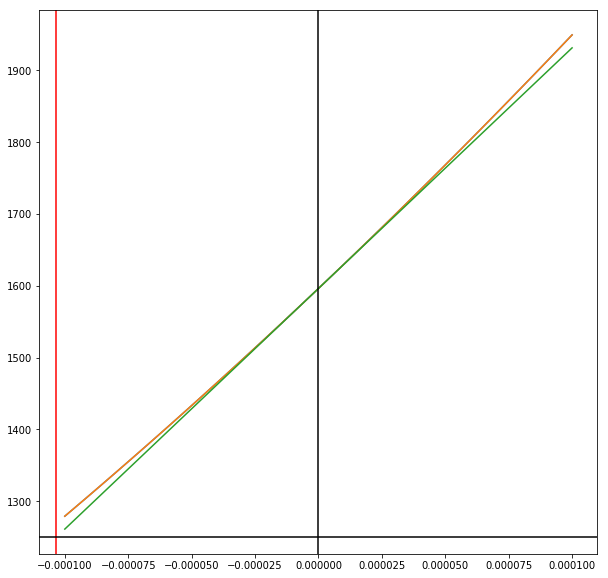

In [29]:
ti = timeit.time.time()
p_res_T = pointcloud_ellipsoidgeoloc_improved_Taylortheta2mu1_check(p_test, s_test, vs_test, 
                                            R_test,3*h_test,
                                            keep_Doppler=False,
                                            keep_R=False,
                                            verbose=True)
tf = timeit.time.time()
print(tf-ti)

print(p_res_T)
print(p_test)
print(p_res_T-p_test)
print(np.linalg.norm(p_res_T-p_test))
print(np.linalg.norm(p_res_T-p_res))
print(height_above_ellispoid(p_res_T, numerical_min=True), h_test)

In [27]:
def pointcloud_ellipsoidgeoloc_improved_Taylortheta2mu1_check(p_noisy, s, vs, 
                                        R_target, h_target, 
                                        keep_Doppler=False, 
                                        #if False uses 0 Doppler, else the value computed from p, s, bs
                                        keep_R=False,
                                        verbose = False):
    
    s_hat = normalize(s)
    # let's define first an adapted orthonormal basis
    v_hat = normalize(vs) #points along track
    u_hat = normalize(np.cross(s_hat, v_hat)) #s and v are almost ortho; no danger of colinear (points roughly cross track)
    w_hat = np.cross(u_hat, v_hat) # points roughly to nadir
    
    r_s = np.linalg.norm(s)
    
    delta = np.dot(p_noisy-s,v_hat) if keep_Doppler else 0.
    R = np.linalg.norm(p_noisy-s) if keep_R else R_target
    
    #OLDlet's choose the sign of mu (discriminates between both swaths) based on the input point
    # mu_input_sign = np.sign(np.dot(p_noisy-s,u_hat))
    
    #initial guess for mu uses the input point for now
    mu = atan2(np.dot(p_noisy-s,u_hat),np.dot(p_noisy-s,w_hat))
    print(mu)
    r_eq = np.sqrt(R**2-delta**2)
    mu += (h_target-h_brut)/r_eq/np.sin(mu)
    
    def Gtilde(mu):
        
        p_mu = s + r_eq*(np.cos(mu)*w_hat + np.sin(mu)*u_hat) + delta*v_hat
        dp_mu_dmu = r_eq*(-np.sin(mu)*w_hat + np.cos(mu)*u_hat)
            
        r2_mu = np.dot(p_mu,p_mu)
        z_mu = p_mu[2]
        d_mu = np.sqrt(r2_mu-z_mu*z_mu)
            
        dr2_dmu = 2*np.dot(p_mu,dp_mu_dmu)
        dz_dmu = dp_mu_dmu[2]
        dd_dmu = (dr2_dmu/2.-z_mu*dz_dmu)/d_mu
    
        
        #initial guess for theta
        alpha = np.sqrt(d_mu**2/R_e**2 + z_mu**2/R_p**2) #homotethy factor for an ellipsoid going through p_noisy
        theta_0 = np.arccos(z_mu/(alpha*R_p))
    
        DR2 = R_e**2-R_p**2
        s_th, c_th = np.sin(theta_0), np.cos(theta_0)
        s_th2 , c_th2 = s_th**2, c_th**2
        G = r2_mu+R_p**2 + DR2*s_th2 - 2*R_e*d_mu*s_th - 2*R_p*z_mu*c_th
        dG_dth = 2*DR2*s_th*c_th - 2*R_e*d_mu*c_th + 2*R_p*z_mu*s_th
        d2G_dth2 = 2*DR2*(c_th2-s_th2) + 2*R_e*d_mu*s_th + 2*R_p*z_mu*c_th
        dG_dmu = dr2_dmu - 2*R_e*dd_dmu*s_th -2*R_p*dz_dmu*c_th
        d2G_dthdmu = -2*R_e*dd_dmu*c_th + 2*R_p*dz_dmu*s_th
        d3G_dth2dmu = 2*R_e*dd_dmu*s_th + 2*R_p*dz_dmu*c_th
    
        A = G - dG_dth**2/d2G_dth2/2
        B = dG_dmu - d2G_dthdmu*dG_dth/d2G_dth2 + dG_dth**2*d3G_dth2dmu/d2G_dth2**2/2
    
        #print('tata',height_above_ellispoid(p_mu)**2,A)
    
        #print(dG_dth/d2G_dth2)
        #print(h_target**2, G , dG_dth**2/d2G_dth2/2)
        #print(dG_dth**2*d3G_dth2dmu/d2G_dth2**2/2, d2G_dthdmu*dG_dth/d2G_dth2, dG_dmu)
        return A,B
    
    delta_mu_tab = np.linspace(-1e-4,1e-4,50)
    Gtilde_tab = np.array([Gtilde(mu+ddd)[0] for ddd in delta_mu_tab])
    def Ghat(mu):
        p_mu = s + r_eq*(np.cos(mu)*w_hat + np.sin(mu)*u_hat) + delta*v_hat
        return height_above_ellispoid(p_mu, numerical_min=True)**2
    Ghat_tab = np.array([Ghat(mu+ddd) for ddd in delta_mu_tab])
    
    A, B = Gtilde(mu)
    def Gtilde_lin(dmu):
        return A + B*dmu
    Gtilde_lin_tab = np.array([Gtilde_lin(ddd) for ddd in delta_mu_tab])
    
    delta_mu = (h_target**2-A)/B
    
    plt.figure(figsize=(10,10))
    plt.plot(delta_mu_tab,Gtilde_tab)
    plt.plot(delta_mu_tab,Ghat_tab)
    plt.plot(delta_mu_tab,Gtilde_lin_tab)
    plt.axvline(0, c='k')
    plt.axvline(delta_mu, c='r')
    plt.axhline(h_target**2, c='k')
    
    
    print(delta_mu)
    #delta_mu = 0.
    p_final = s + r_eq*(np.cos(mu+delta_mu)*w_hat + np.sin(mu+delta_mu)*u_hat) + delta*v_hat
    #print(np.linalg.norm(p_mu+delta_mu*dp_mu_dmu-p_final))
    return p_final
    